## fine tuninig

世の中にはたくさんの学習済みのモデルがあります。それらを使ってfine tuningを行います  
今回はtensorflow_hubにある学習済みモデルを使います。

### 学習済みモデルの再利用

まずはモデルを読み込み、使用してみます。

In [1]:
!sudo pip install -q -U tf-hub-nightly

In [2]:
import tensorflow as tf
import tensorflow_hub as hub

https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4  
今回はこのモデルを使用します。mobile_netは軽量で高速なモデルで、精度もそれなりに高く、非常に使いやすいモデルです。

In [3]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"

IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

In [4]:
!pip install pillow

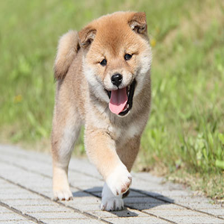

In [6]:
import numpy as np
import PIL.Image as Image

image_url = "https://dol.ismcdn.jp/mwimgs/7/1/670m/img_71c53c1d81500a1cf73a4f543e72413f27838.jpg" # 自分で指定

img = tf.keras.utils.get_file('inu.jpg', image_url)
img = Image.open(img).resize(IMAGE_SHAPE)
img


In [7]:
img = np.array(img) / 255.0
print(img.shape)

(224, 224, 3)


batch_sizeの分だけ次元を増やしてあげてから、predictしてみます。

In [8]:
img = np.expand_dim(img, 0)
result = classifier.predict(img)
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

274

予測結果が得られたので、このclass_idがなんに紐づいているのか定義から確認してみます。

In [9]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())
predicted_class_name = imagenet_labels[predicted_class]
print(predicted_class_name)

dingo


きちんと学習済みで推論できていることが確認できます。 
他にも何枚か試してみてください。

ロードしたモデルについても確認しておきます。

In [10]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              3540265   
Total params: 3,540,265
Trainable params: 0
Non-trainable params: 3,540,265
_________________________________________________________________


Trainable params: 0 からこのモデルが再トレーニングできないモデルなことがわかります。

### 最終層を再学習

tensorflow_hubには完全に使用可能なモデルから、最終層やいくつかの層をあえて取り外し、特徴ベクトルを取り出せるようなモデルもあります。  
今回は際学習が目的なので、特徴量ベクトルだけ取り出し、最終層を際学習させます。

そのため、再度、特徴量ベクトルが取り出すことができるモデルを読み込みます。  
https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4  
ここからurlをコピーして使います。

In [11]:
feature_vector_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

IMAGE_SHAPE = (224, 224)
NUM_CLASSES=2

model = tf.keras.Sequential([
    hub.KerasLayer(feature_vector_url, input_shape=IMAGE_SHAPE+(3,)),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


最終層につけたDenseがTrainableで、特徴量ベクトルの層がUntrainableになっています。

モデルの準備はできたので、学習データセットを用意します。

https://www.tensorflow.org/datasets/catalog/overview  
上記のカタログの中から、  
https://www.tensorflow.org/datasets/catalog/horses_or_humans  
こちらのデータセットを今回は使います。

In [13]:
%%bash
TRAIN_DATA_URL=https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
VAL_DATA_URL=https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
curl -o train.zip ${TRAIN_DATA_URL}
curl -o val.zip ${VAL_DATA_URL}
rm -rf train
rm -rf val
mkdir -p train
mkdir -p val
unzip -qq train.zip -d train
unzip -qq val.zip -d val

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  142M  100  142M    0     0   153M      0 --:--:-- --:--:-- --:--:--  153M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10.9M  100 10.9M    0     0  9234k      0  0:00:01  0:00:01 --:--:-- 9234k


In [15]:
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
train_image_data = train_image_generator.flow_from_directory("./train", target_size=IMAGE_SHAPE)

eval_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
eval_image_data = eval_image_generator.flow_from_directory("./val", target_size=IMAGE_SHAPE)

Using TensorFlow backend.


Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


試しにclassifierで推論してみると、

In [16]:
for image_batch, label_batch in train_image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  result = classifier.predict(image_batch)
  predicted_class = np.argmax(result[0], axis=-1)
  print(imagenet_labels[predicted_class])
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 2)
crutch


## Training

さてデータの準備ができたので、訓練を開始します。

In [17]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['categorical_accuracy'])

In [19]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['categorical_accuracy'])
    self.model.reset_metrics()
    
steps_per_epoch = np.ceil(train_image_data.samples/train_image_data.batch_size)

batch_stats_callback = CollectBatchStats()
history = model.fit_generator(train_image_data, epochs=1,
                              steps_per_epoch=steps_per_epoch,
                              validation_data=eval_image_data,
                              callbacks = [batch_stats_callback])

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


33/33 [==============================] - 8s 238ms/step - loss: 0.0342 - categorical_accuracy: 1.0000 - val_loss: 0.0735 - val_categorical_accuracy: 0.9883


### 可視化
訓練が終わったら、lossとaccuracyの推移を確認してみます。

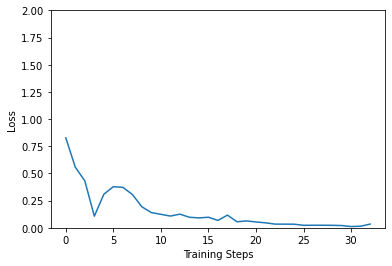

In [20]:
import matplotlib.pylab as plt

plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

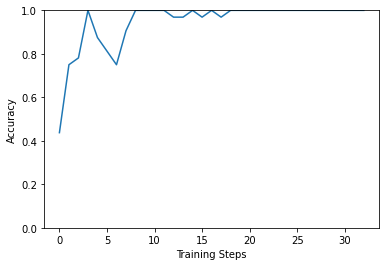

In [21]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)